In [1]:
# import standard libraries
import numpy as np
from scipy.io import mmread, mmwrite
from scipy import linalg
from scipy import sparse
from scipy.integrate import ode
from numba import njit
import matplotlib.pyplot as plt
from pyscf import gto, dft
import numpy.ma as ma

# import methods for solving from other files
import dmm_gcp as gcp
import dmm_cp as cp
import palser as pals
import ntpoly as nt

# Note: using np.sum(A * B.T) for matrices A, B is equivalent to Trace(A^dag B)

In [2]:
'''
A simple example to run DFT calculation.
'''

# PBE Hydrogen flouride in a 6-31G basis set.
mol = gto.Mole()
mol.build(
    atom = 'H 0 0 0; F 0 0 1.1',  # in Angstrom
    basis = '631g',
    symmetry = True,
)

mf = dft.RKS(mol)
#mf.xc = 'blyp' # shorthand for b88,lyp
mf.xc = 'pbe' # shorthand for pbe,pbe
#mf.xc = 'lda,vwn_rpa'
#mf.xc = 'pbe0'
#mf.xc = 'b3lyp'

# this where self-content diagonalization happens
mf.kernel()

# Orbital energies, Mulliken population etc.
mf.analyze()

# Get the converged density matrix (it generates the density matrix)
dm = mf.make_rdm1()
mmwrite('dft_density.mtx', sparse.coo_matrix(dm))


# Get the nuclear-nuclear repulsion energy
e_nuc = mf.energy_nuc()
# Get the 'core' hamiltonian, corresponding to kinetic energy and e-nuclear repulsion terms
h1e = mf.get_hcore()
#mmwrite('dft_hcore.mtx', sparse.coo_matrix(h1e))
e1 = np.einsum('ij,ji', h1e, dm) # Compute the kinetic + e-nuclear repulsion energy
# Get the kohn-sham potential, including the Hartree coulomb repulsion and exchange-correlation potential, integrated on a grid
vhf = mf.get_veff(mf.mol, dm)
#print(type(vhf))
#print(vhf)
# Total energy
tot_e = e1 + vhf.ecoul + vhf.exc + e_nuc    # Total energy is sum of terms
print('Total dft energy: {}'.format(tot_e))

# chemical potential
index = int(mol.nelectron/2)
dft_mu = (mf.mo_energy[index] + mf.mo_energy[index - 1]) / 2.
print('Chemical Potential: ', str(dft_mu))

# get the overlap matrix and print to file
ovlp = mf.get_ovlp()
inv_ovlp = linalg.inv(ovlp)

# Full fock matrix is sum of h1e and vhf
fock = h1e + vhf

# Get whole fock matrix directly corresponding to this density, without computing individual components
fock_direct = mf.get_fock(dm=dm)

# Check that ways to get the fock matrix are the same
assert(np.allclose(fock_direct,fock))

print("DFT trace: ", dm.trace())
core_spect = linalg.eigvalsh(h1e, ovlp)
print("Core eigvals: ", core_spect)
num_electrons = 10
index = int(num_electrons/2)
dmm_mu = (core_spect[index] + core_spect[index-1])/2

converged SCF energy = -100.291327706251
TODO: total wave-function symmetry for Coov
occupancy for each irrep:     A1  E1x  E1y
                               3    1    1
**** MO energy ****
MO #1 (A1 #1), energy= -24.2331671128069 occ= 2
MO #2 (A1 #2), energy= -1.0272972299461 occ= 2
MO #3 (A1 #3), energy= -0.426131190105554 occ= 2
MO #4 (E1x #1), energy= -0.289938520612843 occ= 2
MO #5 (E1y #1), energy= -0.289938520612844 occ= 2
MO #6 (A1 #4), energy= -0.0349559135896386 occ= 0
MO #7 (A1 #5), energy= 0.664675049298747 occ= 0
MO #8 (E1x #2), energy= 1.1305709354121 occ= 0
MO #9 (E1y #2), energy= 1.1305709354121 occ= 0
MO #10 (A1 #6), energy= 1.24759809513674 occ= 0
MO #11 (A1 #7), energy= 1.57280313485609 occ= 0
 ** Mulliken atomic charges  **
charge of  0H =      0.35670
charge of  1F =     -0.35670
Dipole moment(X, Y, Z, Debye):  0.00000,  0.00000, -2.17040
Total dft energy: -100.29132770625066
Chemical Potential:  -0.16244721710124144
DFT trace:  7.124009715257128
Core eigvals:  [-

In [3]:
# Calculate the exact FD distribution
beta = 1
num_steps = 10000
dbeta = beta/num_steps
identity = np.eye(h1e.shape[0])

num = linalg.expm(beta*(inv_ovlp@h1e - dmm_mu*identity))
denom = linalg.inv(identity + num)
exact_P = ovlp @ denom
#exact_P = ovlp @ linalg.funm(inv_ovlp @ h1e, lambda _ : np.exp(-beta*(_ - dmm_mu))/(1+np.exp(-beta*(_ - dmm_mu))))
dft_P = ovlp @ linalg.funm(inv_ovlp @ h1e, lambda _ : np.exp(-beta*(_ - dft_mu))/(1+np.exp(-beta*(_ - dft_mu))))

funm result may be inaccurate, approximate err = 1


In [4]:
# Perform GCP DMM method
identity = np.eye(h1e.shape[0])
dmm_gcp = gcp.rk4(gcp.rhs, ovlp/2, dbeta, h1e, inv_ovlp, identity, dmm_mu, num_steps)

In [5]:
# Perform CP DMM method
init_mu = h1e.trace()/ovlp.trace()
init_rho = num_electrons*ovlp/ovlp.trace()
dmm_cp, cp_mu = cp.rk4(cp.rhs, num_electrons*ovlp/ovlp.trace(), dbeta, h1e, inv_ovlp, identity, num_steps, num_electrons, ovlp, init_mu, 1e-10)
print(init_mu)
print(cp_mu)
#cp_mu = cp.get_mu(dmm_cp, h1e, inv_ovlp, num_electrons, ovlp)
cp_exact_denom = linalg.inv(identity + linalg.expm(beta*(inv_ovlp@h1e - cp_mu*identity)))
cp_exact = 2*num_electrons*ovlp/ovlp.trace() @ cp_exact_denom
#cp_exact = 2*num_electrons*ovlp/ovlp.trace() @ linalg.funm(inv_ovlp @ h1e, lambda _ : np.exp(-beta*(_ - cp_mu))/(1+np.exp(-beta*(_ - cp_mu))))
print(dmm_cp.trace())
print(cp_exact.trace())

-10.541649354791344
-8.247930544995166
10.000000000000016
10.000288921597267


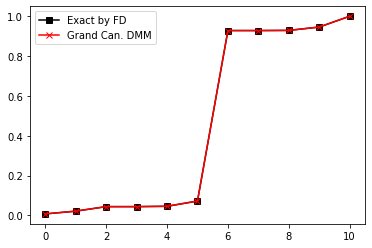

In [6]:
# Plot the eigenvalue spectra of each
plt.plot(linalg.eigvalsh(exact_P, ovlp), 'ks-', label="Exact by FD")
plt.plot(linalg.eigvalsh(dmm_gcp, ovlp), 'rx-', label="Grand Can. DMM")
plt.legend(numpoints=1)

0.00010154230282162475


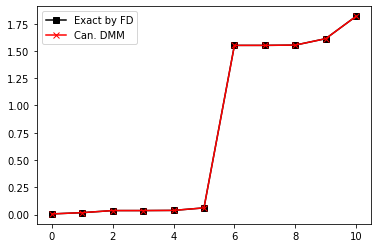

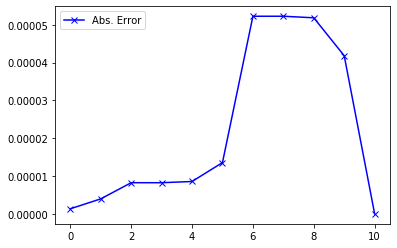

In [7]:
cp_exact_eigs = linalg.eigvalsh(cp_exact, ovlp)
dmm_cp_eigs = linalg.eigvalsh(dmm_cp, ovlp)
plt.plot(cp_exact_eigs, 'ks-', label="Exact by FD")
plt.plot(dmm_cp_eigs, 'rx-', label="Can. DMM")
plt.legend(numpoints=1)

plt.figure(2)
plt.plot(np.abs(dmm_cp_eigs - cp_exact_eigs), 'bx-', label="Abs. Error")
plt.legend(numpoints=1)
print(linalg.norm(dmm_cp_eigs - cp_exact_eigs))

In [8]:
solver = ode(cp.zvode_rhs).set_integrator('zvode', method='bdf')
solver.set_initial_value(np.append(init_rho.reshape(-1),[init_mu]), 0.001).set_f_params(h1e, inv_ovlp, identity, num_electrons, ovlp)

In [9]:
while solver.successful() and solver.t < beta:
    solver.integrate(solver.t + dbeta/10)

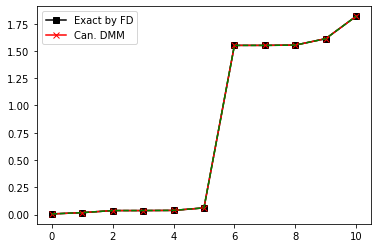

In [10]:
mu = solver.y[-1]
zvode_rho = solver.y[:-1].reshape(*h1e.shape)
plt.plot(linalg.eigvalsh(cp_exact, ovlp), 'ks-', label="Exact by FD")
plt.plot(linalg.eigvalsh(dmm_cp, ovlp), 'rx-', label="Can. DMM")
plt.plot(linalg.eigvalsh(zvode_rho, ovlp), 'g--')
plt.legend(numpoints=1)

In [11]:
print(cp_mu)
print(mu)

-8.247930544995166
(-8.249484058804336+0j)


In [12]:
print(zvode_rho.trace())

(9.999999999999998+0j)
